<a href="https://colab.research.google.com/github/SBH-Top-Coder/Advanced_Cycle_GAN_Monet_PHOTOS_Generator/blob/main/Prepare_CORD_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Installing Dependencies 

In [1]:
!pip install pdf2image
!sudo apt-get install poppler-utils
!rm -r transformers
!git clone -b modeling_layoutlmv2_v2 https://github.com/NielsRogge/transformers.git
!cd tranformers
!pip install -q ./transformers

!pip install -q datasets seqeval
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (564 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 155455 

2 . Utils

In [2]:
from tqdm import tqdm
import os

def train_bbox(bbox): # to do train 
  return [int(bbox[0]*1000) ,int(bbox[1]*1000) ,
          int(bbox[4]*1000) , int(bbox[5]*1000)] 
def real_bbox(bbox,width,height) :  # to plot bboxes 
  return [int(bbox[0]*width) ,int(bbox[1]*height) ,
          int(bbox[4]*width) , int(bbox[5]*height)]
# 1 . Lecture du fichier 
import json
def open_json(file_path):
  with open(file_path, 'r') as j:
      contents = json.loads(j.read())
  return contents
# 2 . Extraction de champs / page : 
def extract_content( contents , page) :
  words = []
  bboxes = []
  labels = []
  for label in (contents['labels']) : 
    for value in (label['value']) :
      if (value['page'] == page ) :
        words.append(value['text'])
        bboxes.append((value['boundingBoxes'][0]))
        labels.append(label['label']) 
  return words,bboxes,labels
# 3. Saving extracted images + it's data + plotting 
def saving_preparing_plotting(contents,images):
  for i in range(len(images)):
      # Save pages as images in the pdf
      images[i].save('/content/images/image_'+ str(len(os.listdir('/content/images'))) +'.png')
      words,bboxes,labels = extract_content(contents , i+1)
      WORDS.append(words)
      normalized_bboxes = [train_bbox(box) for box in bboxes ]
      BBOXES.append(normalized_bboxes)
      LABELS.append(labels)
      draw = ImageDraw.Draw(images[i], "RGB")
      font = ImageFont.load_default()
      for idx , box in enumerate(bboxes) :
        real_box =  real_bbox(box,images[i].width,images[i].height)
        draw.rectangle(real_box , outline  = (255, 0, 0))
        draw.text((real_box[0],real_box[1]),words[idx],fill =(255, 0, 0))

In [3]:
!mkdir /content/images

In [6]:
!unzip /content/IMAGES.zip
!unzip /content/LABELS.zip



Archive:  /content/IMAGES.zip
   creating: IMAGES/
  inflating: IMAGES/bills_BESUtilities_GAS_BES%20GAS.pdf  
  inflating: IMAGES/bills_Dong_GAS_1%20-%20April%2017.pdf  
Archive:  /content/LABELS.zip
   creating: LABELS/
  inflating: LABELS/bills_BESUtilities_GAS_BES%20GAS.pdf.labels.json  
  inflating: LABELS/bills_Dong_GAS_1%20-%20April%2017.pdf.labels.json  


In [7]:
import os 
IMAGES_PDF  = os.listdir('/content/IMAGES') 
LABELS_JSON =  os.listdir('/content/LABELS')

In [26]:
from pdf2image import convert_from_path
from PIL import ImageDraw, ImageFont
import cv2
WORDS = []
BBOXES = []
LABELS = []
for image,label in zip(IMAGES_PDF,LABELS_JSON) : 
  contents =open_json(os.path.join('/content/LABELS',label))
  images = convert_from_path(os.path.join('/content/IMAGES',image))
  saving_preparing_plotting(contents,images)
    

In [31]:
contents =open_json('/content/LABELS/bills_BESUtilities_GAS_BES%20GAS.pdf.labels.json')
images = convert_from_path('/content/IMAGES/bills_BESUtilities_GAS_BES%20GAS.pdf')
for i in range(len(images)):
      # Save pages as images in the pdf
      images[i].save('/content/images/image_'+ str(len(os.listdir('/content/images'))) +'.png')
      words,bboxes,labels = extract_content(contents , i+1)
      WORDS.append(words)
      normalized_bboxes = [train_bbox(box) for box in bboxes ]
      BBOXES.append(normalized_bboxes)
      LABELS.append(labels)
      draw = ImageDraw.Draw(images[i], "RGB")
      font = ImageFont.load_default()
      for idx , box in enumerate(bboxes) :
        real_box =  real_bbox(box,images[i].width,images[i].height)
        draw.rectangle(real_box , outline  = (255, 0, 0))
        draw.text((real_box[0],real_box[1]),words[idx],fill =(255, 0, 0))

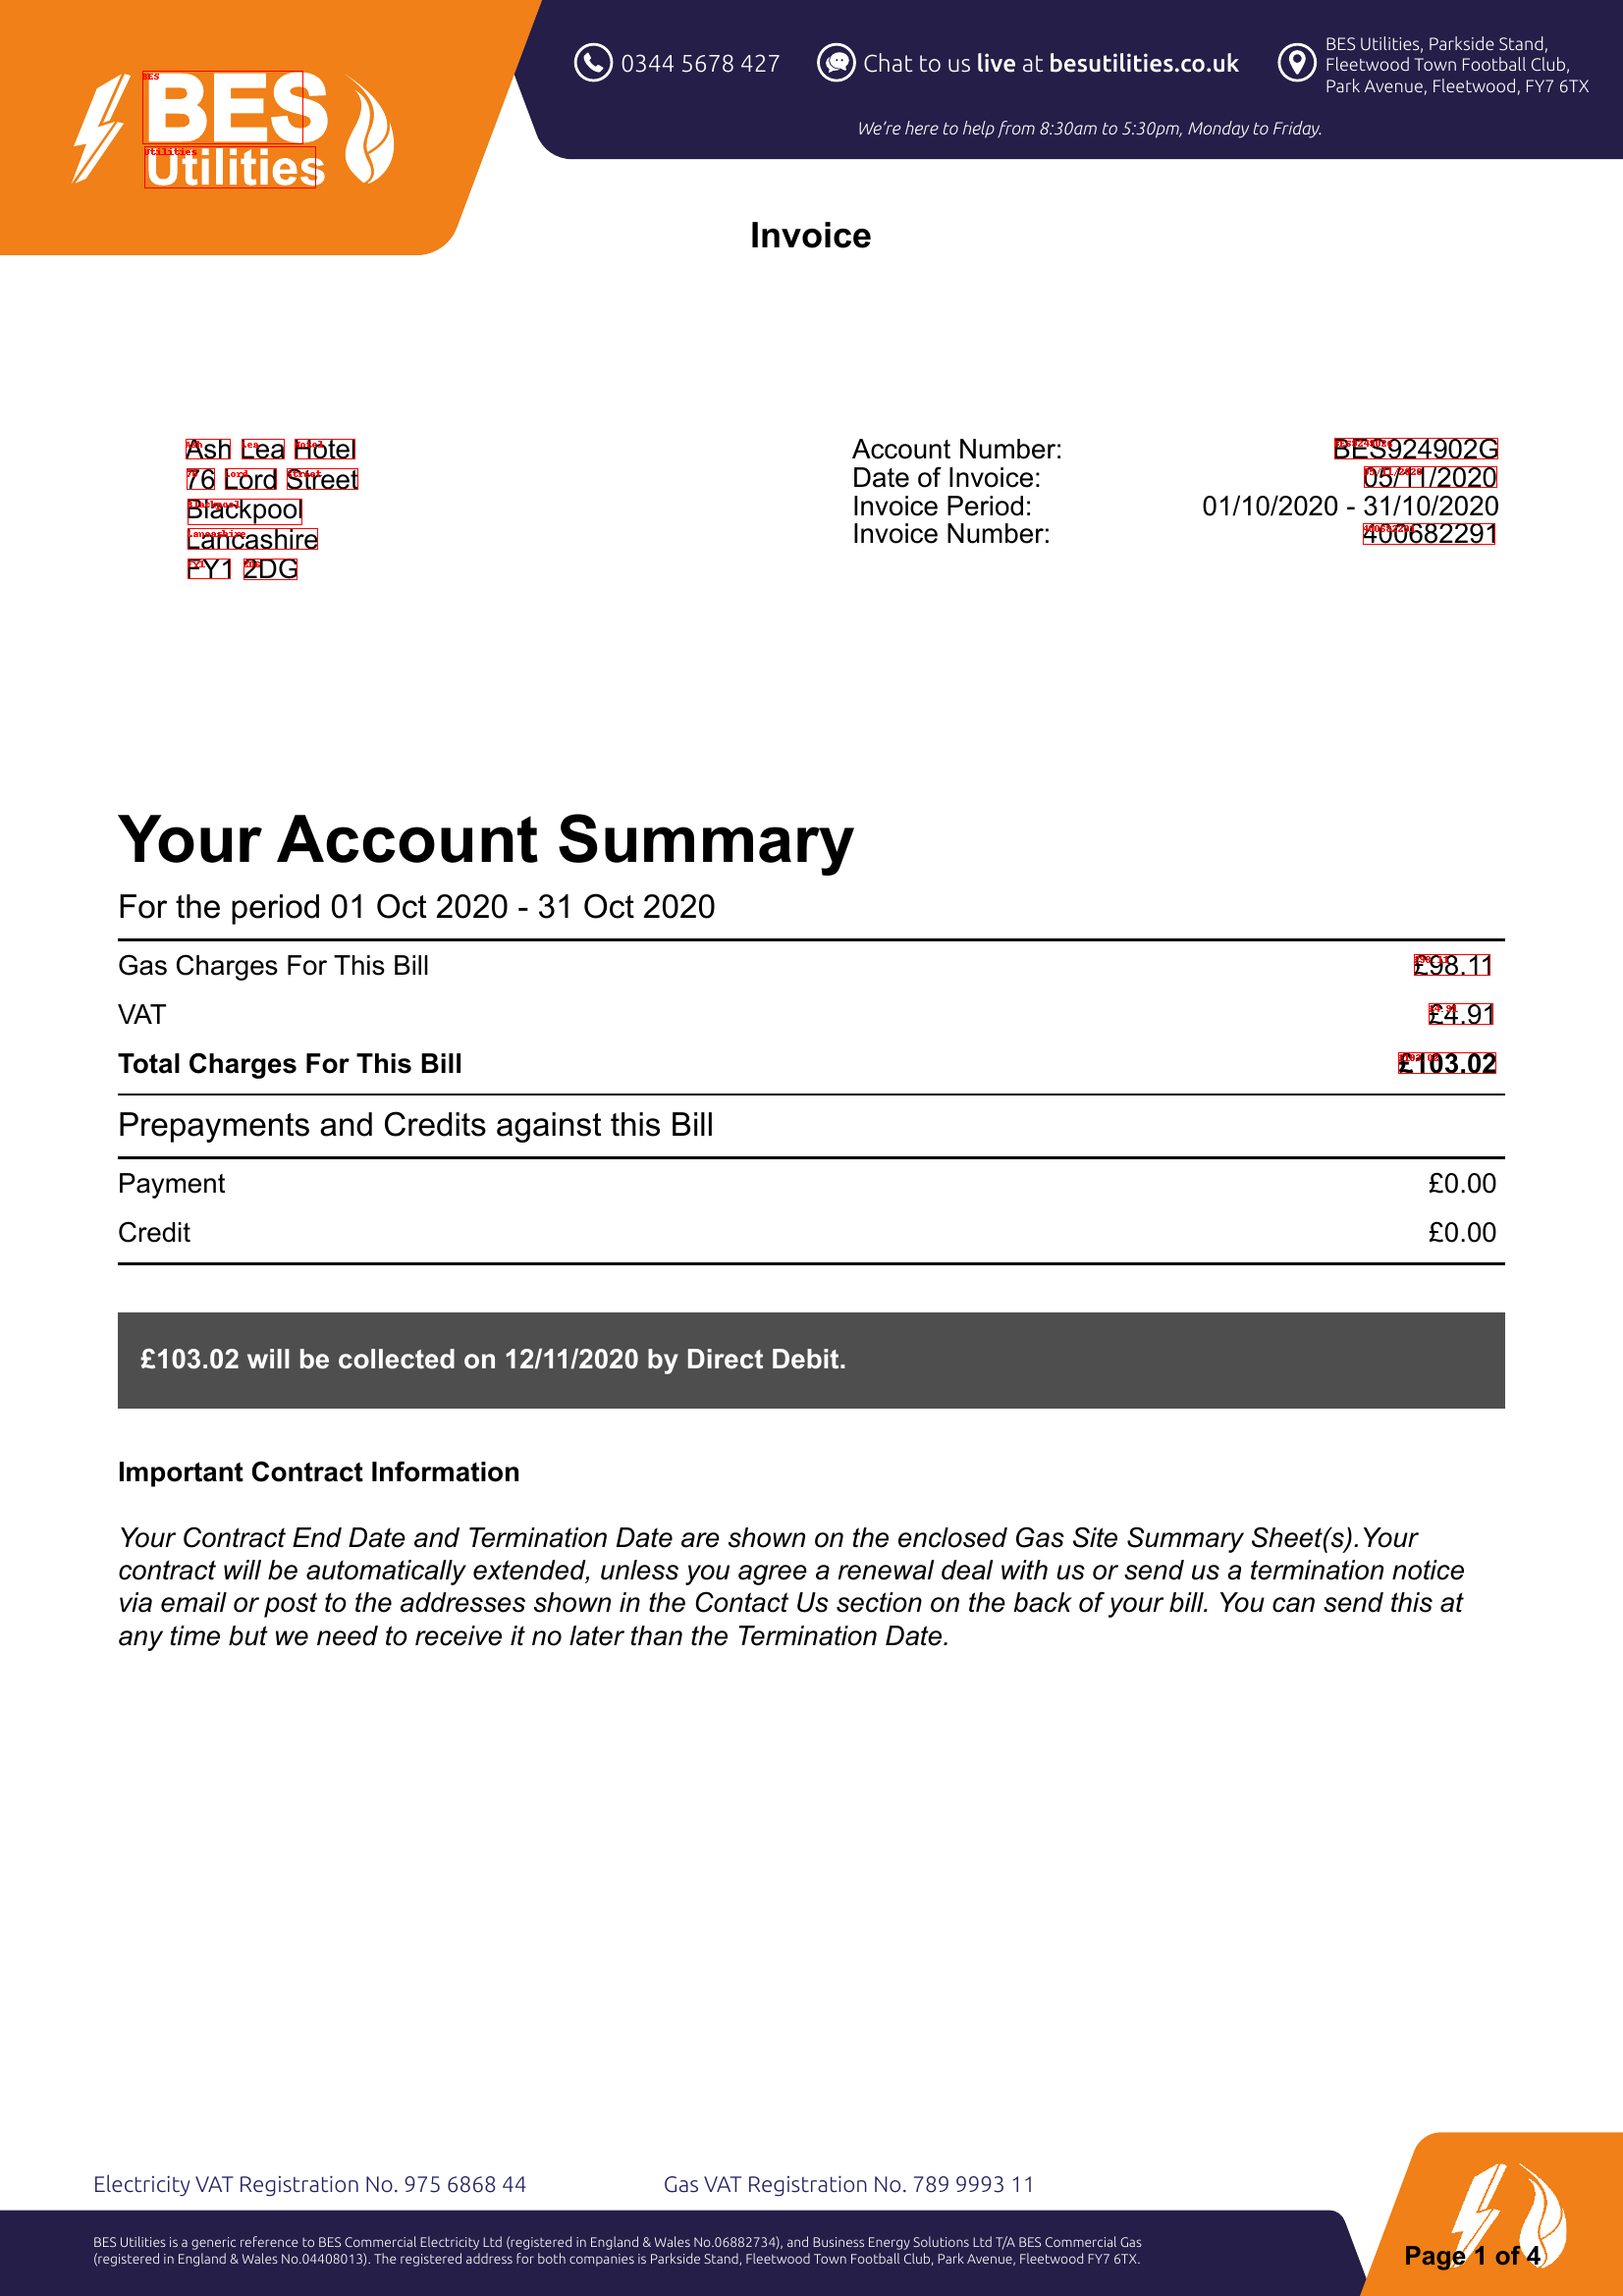

In [32]:
images[0]

2 . Json Extraction

In [10]:
import pickle
with open('/content/train.pkl', 'wb') as t:
    pickle.dump([WORDS,BBOXES,LABELS ], t)
    

In [11]:
import pandas as pd
train = pd.read_pickle('/content/train.pkl')

In [12]:
len(LABELS)

6

In [13]:
labels = []
for x in LABELS  : 
  for y in x : 
    if y not in labels : 
      labels.append(y)
labels

['supplyAddress',
 'supplierName',
 'totalChargesIncVAT',
 'totalVat',
 'totalChargesExcVAT',
 'accountNumber',
 'customerName',
 'invoiceDate',
 'invoiceNumber',
 'billingAddress',
 'meterNumber',
 'table/0/periodStart',
 'table/0/periodEnd',
 'table/0/cc.total',
 'table/1/cc.name',
 'table/1/periodStart',
 'table/1/periodEnd',
 'table/1/cc.unitValue',
 'table/1/cc.unitLabel',
 'table/1/cc.rate',
 'table/1/cc.vat',
 'table/1/cc.total',
 'table/2/cc.name',
 'table/2/cc.total',
 'meterType',
 'meterSerial',
 'table/0/cc.vat',
 'table/0/cc.rate',
 'table/0/cc.unitValue',
 'readings_table/0/r.previous.value',
 'readings_table/0/r.previous.date',
 'readings_table/0/r.current.value',
 'readings_table/0/r.current.date']

In [14]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'supplyAddress': 0, 'supplierName': 1, 'totalChargesIncVAT': 2, 'totalVat': 3, 'totalChargesExcVAT': 4, 'accountNumber': 5, 'customerName': 6, 'invoiceDate': 7, 'invoiceNumber': 8, 'billingAddress': 9, 'meterNumber': 10, 'table/0/periodStart': 11, 'table/0/periodEnd': 12, 'table/0/cc.total': 13, 'table/1/cc.name': 14, 'table/1/periodStart': 15, 'table/1/periodEnd': 16, 'table/1/cc.unitValue': 17, 'table/1/cc.unitLabel': 18, 'table/1/cc.rate': 19, 'table/1/cc.vat': 20, 'table/1/cc.total': 21, 'table/2/cc.name': 22, 'table/2/cc.total': 23, 'meterType': 24, 'meterSerial': 25, 'table/0/cc.vat': 26, 'table/0/cc.rate': 27, 'table/0/cc.unitValue': 28, 'readings_table/0/r.previous.value': 29, 'readings_table/0/r.previous.date': 30, 'readings_table/0/r.current.value': 31, 'readings_table/0/r.current.date': 32}
{0: 'supplyAddress', 1: 'supplierName', 2: 'totalChargesIncVAT', 3: 'totalVat', 4: 'totalChargesExcVAT', 5: 'accountNumber', 6: 'customerName', 7: 'invoiceDate', 8: 'invoiceNumber', 9: '

In [15]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.boxes , self.labels = annotations
        self.image_dir = image_dir
        self.image_file_names = [f for f in listdir(image_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]
        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [16]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

train_dataset = CORDDataset(annotations=train,
                            image_dir='/content/images/', 
                            processor=processor)

Downloading:   0%|          | 0.00/136 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [17]:
encoding = train_dataset[0]
encoding.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [18]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
token_type_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
image torch.Size([3, 224, 224])


In [19]:
print(processor.tokenizer.decode(encoding['input_ids']))


[CLS] 76 lord street blackpool lancashire fy1 2dg bes utilities £103. 02 £4. 91 £98. 11 bes924902g ash lea hotel 05 / 11 / 2020 400682291 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [21]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                                      num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4



Downloading:   0%|          | 0.00/802M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res3.1.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv2.norm.num_batches_tracke

In [23]:
#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss
        # print loss every 100 steps
        # if global_step % 100 == 0:
        loss.backward()
        optimizer.step()
        global_step += 1
   print(loss)


model.save_pretrained("/content/drive/MyDrive/LayoutLMv2/Tutorial notebooks/CORD/Checkpoints")

Epoch: 0


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(3.1818, grad_fn=<NllLossBackward>)
Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(3.1156, grad_fn=<NllLossBackward>)
Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(3.1682, grad_fn=<NllLossBackward>)
Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0., grad_fn=<NllLossBackward>)
